In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
%load_ext autoreload
%autoreload 2

import os
import sys

"""
NOTE
To have a shared folder appear in your own google drive, 
click on the down arrow for the folder and click "add shortcut to drive".
"""
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'EECS487 Final Project/'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))
sys.path.append(GOOGLE_DRIVE_PATH)

['cong_politician_tweets_2020-3-12-2021-5-28_text_party_balanced_anonymous.csv', 'nonpolitician_users129_tweets_2021-05-30_anonymous.csv', 'Project Progress Report.gdoc', 'ProjectProposal.pdf', '__pycache__', 'ProgressReport.pdf', '.ipynb_checkpoints', 'EECS487 Project Proposal.gdoc', 'vectors.kv', 'vectors.kv.vectors.npy', 'rnn.py', 'preprocess.py', 'logistic_reg.py', 'naive_bayes.py', 'Hyperparameter Results.gsheet', 'Final Presentation.gslides', 'ideology_detection.ipynb']


In [3]:
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [32]:
import pandas as pd
import numpy as np
import random
import gensim.downloader
from preprocess import extract_features, process_tweet, handle_UNK, embed_features
from naive_bayes import train_naive_bayes, naive_bayes_predict
from logistic_reg import gradientDescent, test_logistic_regression, sigmoid
from torch import nn
from rnn import RNNModel
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt

Load Data

In [5]:
filename = GOOGLE_DRIVE_PATH + "cong_politician_tweets_2020-3-12-2021-5-28_text_party_balanced_anonymous.csv"
# TODO: also load tweets from non-politicians?
data = pd.read_csv(filename)

In [6]:
print(data.head)
print(data.columns)

<bound method NDFrame.head of                     status_id           created_at  \
0         x649659448751992833  2015-10-01 18:57:37   
1        x1089996836725841926  2019-01-28 21:21:11   
2        x1155945861739716610  2019-07-29 20:59:04   
3         x711713134331826176  2016-03-21 00:36:48   
4        x1029813906234122242  2018-08-15 19:35:42   
...                       ...                  ...   
2809157    x65171403263066112  2011-05-02 21:50:48   
2809158  x1397945764341600256  2021-05-27 16:00:17   
2809159   x459774204859019264  2014-04-25 19:21:27   
2809160  x1290290244919554048  2020-08-03 14:15:41   
2809161   x928318724670656515  2017-11-08 17:50:05   

                                                      text party  
0        Sgt. Martland should be commended - not punish...     R  
1        Don’t be fooled by the President’s tweets. The...     D  
2        As if decriminalizing illegal immigration and ...     R  
3        Good luck to @BadgerMBB! #OnWisconsin #March

Split into train/test

In [7]:
p = data.groupby("party")
republican_data = p.get_group('R') # R == 1
democrat_data = p.get_group('D') # D == 0

# TODO: improve performance by trying different train/test splits
train_length = int(0.8 * len(data))

# converted df to word bank (train: 10,000, test: 2,000 data points)
test_rep = republican_data.loc[10000:12000, "text"].tolist()
# test_rep = ' '.join(test_rep)
test_dem = democrat_data.loc[10000:12000, "text"].tolist()
# test_dem = ' '.join(test_dem)

test_X = test_rep + test_dem

test_X = np.array(test_X)

test_rep_Y = np.ones(len(test_rep))
test_dem_Y = np.zeros(len(test_dem))

test_Y = np.concatenate((test_rep_Y, test_dem_Y))

train_rep = republican_data.loc[:8000, "text"].tolist()
# train_rep = ' '.join(train_rep)
train_dem = democrat_data.loc[:8000, "text"].tolist()
# train_dem = ' '.join(train_dem) 

train_X = train_rep + train_dem

train_X = np.array(train_X)

train_rep_Y = np.ones(len(train_rep))
train_dem_Y = np.zeros(len(train_dem))

train_Y = np.concatenate((train_rep_Y, train_dem_Y))

assert len(test_X) == len(test_Y)

assert len(train_Y) == len(train_X)


val_rep = republican_data.loc[8000:10000, "text"].tolist()
val_dem = republican_data.loc[8000:10000, "text"].tolist()
# TODO: add validation to model -- hyperparameter tuning
# print(train_rep[0])

Preprocess Data

In [8]:
# Uncomment when first running code
import nltk
import collections
nltk.download('stopwords')

# NOTE: another option instead of a dictionary frequency is bag-of-words (no words as keys)

# process training data
# freqs_rep, tweets_rep = process_tweet(train_rep, 1)
# freqs_dem, tweets_dem = process_tweet(train_dem, 0)
# train_tweets = tweets_rep + tweets_dem

freqs = {}
freqs_dem = {}
freqs_rep = {}

tweets_rep = []
tweets_dem = []

print(len(train_rep))
for tweet in train_rep:
  n_freq, processed_tweet = process_tweet(tweet, 1)
  freqs_rep.update(n_freq)
  tweets_rep.append(processed_tweet)

for tweet in train_dem:
  n_freq, processed_tweet = process_tweet(tweet, 0)
  freqs_dem.update(n_freq)
  tweets_dem.append(processed_tweet)

# print(tweets_dem[0])

handle_UNK(freqs_dem, 0)
handle_UNK(freqs_rep, 1)

freqs = freqs_rep.copy()
freqs.update(freqs_dem)

train_tweets = tweets_rep + tweets_dem

print(freqs)
# Y_TRAIN
Y = np.append(np.ones((len(tweets_rep), 1)), np.zeros((len(tweets_dem), 1)), axis=0)
assert len(Y) == len(train_tweets)

r = []
d = []
for tweet in val_rep:
  _, r_tweet = process_tweet(tweet, 1)
  r.append(r_tweet)

for tweet in val_dem:
  _, d_tweet = process_tweet(tweet, 0)
  d.append(d_tweet)

val_tweets = r + d
# Y_TEST
val_party = np.append(np.ones((len(r), 1)), np.zeros((len(d), 1)), axis=0)

# NOTE: if we want to sort freqs, also have to sort labels (Y)
#freqs = {key: freqs[key] for key in sorted(freqs.keys(), key = lambda ele: ele[0])}
print("number of republican frequencies:", len(freqs_rep))
print("number of democratic frequencies:", len(freqs_dem))
print("combined frequencies:", len(freqs))

# process test data
# _, r = process_tweet(test_rep, 1)
# _, d = process_tweet(test_dem, 0)
# test_tweets = r + d

r = []
d = []
for tweet in test_rep:
  _, r_tweet = process_tweet(tweet, 1)
  r.append(r_tweet)

for tweet in test_dem:
  _, d_tweet = process_tweet(tweet, 0)
  d.append(d_tweet)

test_tweets = r + d
# Y_TEST
test_party = np.append(np.ones((len(r), 1)), np.zeros((len(d), 1)), axis=0)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
3993
{('bank', 1): 2, ('local', 1): 2, ('tax', 1): 2, ('vaccin', 1): 2, ('passport', 1): 2, ('tribut', 1): 2, ('chief', 1): 2, ('nass', 1): 2, ('celebr', 1): 2, ('–', 1): 2, ('twin', 1): 2, ('miner', 1): 2, ('peyton', 1): 2, ('el', 1): 3, ('un', 1): 2, ('veteran', 1): 2, ('author', 1): 2, ('rule', 1): 2, ('\u2066', 1): 2, ('\u2069', 1): 2, ('louisiana', 1): 2, ('wwii', 1): 2, ('medal', 1): 2, ('cost', 1): 2, ('earli', 1): 2, ('40', 1): 2, ('rural', 1): 2, ('father', 1): 2, ('mean', 1): 2, ('benton', 1): 2, ('mask', 1): 2, ('fallen', 1): 2, ('rescu', 1): 2, ('walt', 1): 2, ('🔹', 1): 3, ('lie', 1): 2, ('cbp', 1): 2, ('infantri', 1): 2, ('properti', 1): 2, ('german', 1): 2, ('florida', 1): 2, ('det', 1): 2, ('skernivitz', 1): 2, ('paid', 1): 3, ('monument', 1): 2, ('nfl', 1): 3, ('control', 1): 2, ('usagm', 1): 2, ('epa', 1): 2, ('ok', 1): 2, ('nurs', 1): 2, ('lakeeri', 1): 3, ('

Train Data -- Logistic Regression

In [9]:
X = np.zeros((len(train_tweets), 3)) # 3 because (bias, rep, dem)
for i in range(len(train_tweets)):
    X[i, :]= extract_features(train_tweets[i], freqs)
print(X)
# NOTE: might want Js to be decreasing (cost) currently constant around 0.693
J, theta = gradientDescent(X, Y, np.zeros((3, 1)), 1e-7, 1500) # TODO: tune learning_rate
print(f"The cost after training is {J:.8f}.")
print(f"The resulting vector of weights is {[round(t, 8) for t in np.squeeze(theta)]}")

[[1. 0. 0.]
 [1. 0. 2.]
 [1. 0. 0.]
 ...
 [1. 0. 8.]
 [1. 4. 4.]
 [1. 2. 0.]]
The cost after training is 0.69314051.
The resulting vector of weights is [-1.4e-07, 8.27e-06, -3.055e-05]


Testing -- Logistic Regression

In [30]:
# same results everytime, might be something wrong with test_party
accuracy, f1 = test_logistic_regression(test_tweets, test_party, freqs, theta)
print(f"accuracy: {accuracy}, f1_score: {f1}")

accuracy: 0.5137431284357821, f1_score: 0.6518783542039356


Hyperparameter Tuning -- Logistic Regression

In [11]:
%pip install sklearn
from sklearn.model_selection import GridsearchCV
from sklearn.ensemble import RandomForestClassifier
estimator = RandomForestClassifier()

# USE val_tweets and val_party for hyperparameter tuning

ImportError: ignored

Train Data -- Naives Bayes

In [11]:
# TODO -- can also use RNN as model (or both and compare in paper)


# call train fxn in naive_bayes.py
# fr_copy = freqs_rep.copy()
# fd_copy = freqs_dem.copy()

# print(fr_copy)
# print(fd_copy)

# print(freqs['UNK'])
logprior, loglikelihood = train_naive_bayes(freqs, X, Y)

print("logprior: " + str(logprior))
print("loglikelyhood" + str(loglikelihood))

preds = []
# call test fxn in naive_bayes.py
for tweet in test_tweets:
  pred = naive_bayes_predict(tweet, logprior, loglikelihood)
  #pred = sigmoid(pred)
  if pred > 0:
    preds.append(1)
  else:
    preds.append(0)


assert len(preds) == len(test_party)
acc = 0

for i, label in enumerate(test_party):
  if label == preds[i]:
    acc += 1

acc /= len(test_party)
print(test_party)
print(acc)


logprior: [-0.00374954]
loglikelyhood{'ddf': 1.1255764958964651, '🔹': 1.4132585683482461, 'escolar': 1.1255764958964651, 'censo': -1.071648081439754, '9/11': -1.071648081439754, 'gottheim': -1.071648081439754, 'restaurantsact': 1.1255764958964651, 'vaccin': -0.26071786522342544, 'aj': -1.3593301538915352, 'hammer': 1.6364021196624559, '1963': 1.1255764958964651, 'mental': -1.071648081439754, '😴': 1.4132585683482461, 'tail': 1.1255764958964651, 'elaina': 1.1255764958964651, '‣': 1.6364021196624559, 'alga': -1.071648081439754, 'patient': 1.1255764958964651, 'cu': -1.071648081439754, 'dupe': -1.071648081439754, 'relev': 1.1255764958964651, 'leav': 1.4132585683482461, 'cfpb': 1.1255764958964651, 'tariff': -1.071648081439754, "army'": 1.1255764958964651, 'lanka': -1.071648081439754, 'hagedorn': 1.1255764958964651, 'georgetown': -1.071648081439754, 'musician': 1.1255764958964651, 'nemtsov': 1.1255764958964651, 'sondland': 1.1255764958964651, 'debit': 1.1255764958964651, 'isi': -1.07164808143

Hyperparameter Tuning -- Naives Bayes

In [ ]:
# TODO 
# USE val_tweets and val_party for hyperparameter tuning

LSTM

In [12]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from nltk.tokenize.casual import TweetTokenizer
from nltk.probability import FreqDist

# https://github.com/chouhbik/Sentiment-Analysis-of-Tweets/blob/master/Tweets%20Analysis%20DemvsRep.ipynb

In [13]:
# initialize tokenizer
tokenizer = TweetTokenizer(reduce_len=True)

# fix random seed for reproducibility
np.random.seed(7)

In [14]:
top_words = 10000  # We'll keep these many distinct tokens and drop less frequent ones


# Tokenize using the TweetTokenizer

train_X_lstm = [tokenizer.tokenize(tweet) for tweet in train_X]

test_X_lstm = [tokenizer.tokenize(tweet) for tweet in test_X]

# Get the word counts
fdist_train = FreqDist(word for tweet in train_X_lstm for word in tweet)
# Get top top_words terms, in order of frequency
terms = [term for term, count in fdist_train.most_common(top_words)]
# Replace all tokens with their rank (or 0 if not in the top top_words)
f = lambda tweet: [terms.index(term) if term in terms else 0 for term in tweet]
train_tweets_lstm = [f(tweet) for tweet in train_X_lstm]
test_tweets_lstm = [f(tweet) for tweet in test_X_lstm]

print(train_tweets_lstm)

[[3466, 0, 0, 90, 27, 7374, 36, 45, 0, 11, 299, 2, 71, 7375, 16, 7376, 83, 523, 7, 51, 2074, 0, 0], [133, 160, 5653, 667, 494, 4, 775, 372, 93, 104, 7, 667, 3097, 3098, 563, 3, 86, 33, 1, 7377, 33, 2555, 23, 90, 291, 2219, 7, 667, 3097, 107, 0], [589, 1931, 2, 0, 11, 5654, 4657, 0], [32, 53, 39, 59, 11, 2556, 2, 27, 42, 3467, 3, 4, 255, 191, 73, 13, 1, 319, 3468, 11, 0, 0], [123, 1368, 2, 100, 48, 13, 0, 2557, 199, 3, 0, 3, 171, 95, 0, 208, 268, 816, 34, 775, 3099, 0, 2, 137, 3100, 325, 3101, 901, 2811, 486, 4, 2220, 0, 0, 0, 0], [326, 70, 90, 26, 35, 256, 874, 0, 2, 4658, 35, 391, 2221, 0, 14, 3469, 7378, 108, 17, 83, 3, 1, 326, 3470, 2558, 7, 4659, 0, 82, 3, 171, 0, 155, 202, 5, 543, 0, 0, 0], [0, 15, 33, 604, 363, 3966, 3967, 5, 440, 8, 2559, 7, 1, 80, 33, 4660, 0], [111, 10, 222, 2, 53, 0, 685, 2, 1613, 12, 185, 6, 1, 2812, 5, 209, 0, 133, 23, 141, 2, 1816, 16, 1613, 3, 1, 1205, 5, 1, 446, 185, 16, 2222, 28, 27, 8, 7379, 875, 0, 0, 2223, 0, 0], [373, 73, 7, 12, 139, 928, 18, 1614, 

In [15]:
assert len(train_tweets_lstm) == len(train_Y)

In [16]:
train_tweets_lstm = np.array(train_tweets_lstm)
test_tweets_lstm = np.array(test_tweets_lstm)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


In [17]:
max_review_length = 50 # The handful tweet are longer than 50 tokens
train_tweets_lstm = sequence.pad_sequences(train_tweets_lstm, maxlen=max_review_length)
test_tweets_lstm = sequence.pad_sequences(test_tweets_lstm, maxlen=max_review_length)

assert len(train_tweets_lstm) == len(train_Y)
assert len(test_tweets_lstm) == len(test_Y)


In [18]:
# create the model
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(top_words, embedding_vecor_length, input_length=max_review_length))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
model.fit(train_tweets_lstm, train_Y, epochs=3, batch_size=64)
# Final evaluation of the model
scores = model.evaluate(test_tweets_lstm, test_Y, verbose=0)
print("Validation accuracy: %.2f%%" % (scores[1]*100))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 32)            320000    
                                                                 
 conv1d (Conv1D)             (None, 50, 32)            3104      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 25, 32)           0         
 )                                                               
                                                                 
 lstm (LSTM)                 (None, 100)               53200     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 376,405
Trainable params: 376,405
Non-trainable params: 0
__________________________________________________

In [33]:
preds = np.round(model.predict(test_tweets_lstm).ravel())
print(test_Y)
print(preds)
t_Y = test_Y.astype(int)
p = preds.astype(int)
print(len(t_Y))
print(len(p))
print(t_Y)
print(p)
f1_lstm = f1_score(t_Y, p)
print(f1_lstm)
print('Accuracy: {}'.format(str(round(accuracy_score(test_Y, preds), 4))))
print('F1 Score:', str(f1_lstm))

[1. 1. 1. ... 0. 0. 0.]
[1. 0. 0. ... 1. 0. 0.]
2001
2001
[1 1 1 ... 0 0 0]
[1 0 0 ... 1 0 0]
0.6169977924944812
Accuracy: 0.6532
F1 Score: 0.6169977924944812


Train - RNN

In [ ]:
from gensim.models import KeyedVectors
embed = gensim.downloader.load('word2vec-google-news-300')


[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [ ]:
embed.save(GOOGLE_DRIVE_PATH + "vectors.kv")

KeyboardInterrupt: ignored

In [ ]:
from gensim.models import KeyedVectors
embed = KeyedVectors.load(GOOGLE_DRIVE_PATH + 'vectors.kv')

In [ ]:
""" REFERENCES """
# code: https://github.com/gabrielloye/RNN-walkthrough/blob/master/main.ipynb
# related work: https://joonleesky.github.io/assets/pdf/ideology_detection.pdf
# TODO: more training
train_processed = embed_features(train_tweets, embed) # train_processed might have to be tensor
train_processed = torch.Tensor(train_processed)
#print(train_processed)
#exit()
target_seq = torch.Tensor(Y)  

val_processed = embed_features(val_tweets, embed)
val_processed = torch.Tensor(val_processed)
val_target = torch.Tensor(val_party)

# should hidden size be word embedding associated with one word?
model = RNNModel(input_size=300, hidden_size=20, n_layers=1, device=device) # TODO: different hidden_size
model = model.to(device)
lr = 0.01
wd = 0.01
n_epochs = 40
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
criterion = nn.CrossEntropyLoss()

input_seq = train_processed.to(device)
val_seq = val_processed.to(device)
train_losses = []
val_losses = []
for epoch in range(1, n_epochs + 1):
    #model.train()
    optimizer.zero_grad() # Clears existing gradients from previous epoch
    output, hidden = model(input_seq)
    output = output.to(device)
    target_seq = target_seq.to(device)
    #input_seq = input_seq.to(device)
    loss = criterion(output, target_seq.long())
    train_losses.append(float(loss))
    loss.backward() # Does backpropagation and calculates gradients
    optimizer.step() # Updates the weights accordingly

    """ VALIDATION """
    #model.eval()
    # NOTE: not sure if this is right (and what we can/cannot reuse from training when validating)
    val_output, hidden = model(val_seq)
    val_output = val_output.to(device)
    val_target = val_target.to(device)
    val_loss = criterion(val_output, val_target.long())
    val_losses.append(float(val_loss))
    val_loss.backward()
    
    if epoch%10 == 0:
        print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
        print("Loss: {:.4f}".format(loss.item()))

[autoreload of rnn failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
  File "drive/My Drive/EECS487 Final Project/rnn.py", line 17
    break
    ^
SyntaxError: 'break' outside loop
]


one tweet shape: torch.Size([46, 300])
output shape: torch.Size([16001, 46, 300])
one tweet shape: torch.Size([45, 300])
output shape: torch.Size([3974, 45, 300])
Epoch: 10/40............. Loss: 2.0185
Epoch: 20/40............. Loss: 1.3343
Epoch: 30/40............. Loss: 1.3443
Epoch: 40/40............. Loss: 1.1402


Plot Loss - RNN

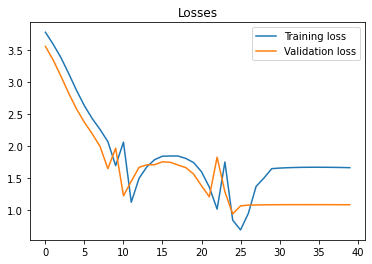

In [ ]:
plt.plot(train_losses, label="Training loss")
plt.plot(val_losses, label="Validation loss")
plt.legend()
plt.title("Losses")
plt.show()
#plt.close()

Hyperparameter Tuning - RNN

In [ ]:
# TODO: 
  # training: learning rate, weight decay, number of epochs
    # optimizer, criterion
  # architecture: hidden size, activation function (none currently?)
  # USE val_tweets and val_party for hyperparameter tuning
best_hyperparameters = {}
lowest_loss = np.Inf
lrs = []
wds = []
model = model.to(device)

n_epochs = 50
for i in range(15): # TODO: diff values
  lr = random.choice(lrs)
  wds = random.choice(wds)
  optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
  criterion = nn.CrossEntropyLoss()

  input_seq = train_processed.to(device)
  train_loss = []
  for epoch in range(1, n_epochs + 1):
      optimizer.zero_grad() # Clears existing gradients from previous epoch
      output, hidden = model(input_seq)
      output = output.to(device)
      target_seq = target_seq.to(device)
      # is min loss same as max accuracy
      loss = criterion(output, target_seq.long())
      train_loss.append(float(loss))
      loss.backward() # Does backpropagation and calculates gradients
      optimizer.step() # Updates the weights accordingly
      
      if epoch%10 == 0:
          print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
          print("Loss: {:.4f}".format(loss.item()))
  avg_loss = sum(train_loss) / len(train_loss)
  if avg_loss < lowest_loss:
    avg_loss = lowest_loss
    best_hyperparameters = {"learning_rate": lr,
                            "weight_decay": wd}
print("best hyperparameters:", best_hyperparameters)
# NOTE: not sure if I can tune lr and wd for an optimizer when it's inside the training loop?

IndexError: ignored

Test - RNN

In [ ]:
test_tweets = embed_features(test_tweets, embed)
test_tweets = torch.Tensor(test_tweets) 
test_party = torch.Tensor(test_party) 
y_true = test_party
print("tweet shape:", test_tweets.shape)
print("label shape:", test_party.shape)

batch_size=1
n_features=1
with torch.no_grad():
  x = test_tweets
  x = x.to(device)
  model.eval()
  yhat, _ = model(x) # not too sure what output here is (2001, 41, 1)
  print(yhat)
  sigmoid = torch.nn.Sigmoid()
  probs = sigmoid(yhat)

  y_pred = []
  # NOTE: scores same everytime I run?
  #for p in probs: 
  zero_count = 0
  one_count = 0
  for i in range(probs.shape[0]):
    p = probs[i][0] # [0] because probs[i] list of 42 of the same values
    #print(p)
    # >0.5 belongs to 1 -- rep
    if float(p) > 0.5: 
      y_pred.append(0)
      zero_count += 1
    else:
      y_pred.append(1) # could be swapped (f1 score is 0.0 when swapped -- maybe add 1?)
      one_count += 1

print("num zeros:", zero_count)
print("num ones:", one_count)
print("y_pred:", y_pred)  # only 1s?
accuracy = accuracy_score(y_true, y_pred)
y_true = y_true.squeeze(1).tolist()
y_true = [int(x) for x in y_true]
f1 = f1_score(y_true, y_pred)
print("y_true:", y_true)
# print(f1_score(y_true, y_pred))
print("accuracy for RNN:", accuracy)
print("f1_score for RNN:", f1)

one tweet shape: torch.Size([46, 300])
output shape: torch.Size([4001, 46, 300])
tweet shape: torch.Size([4001, 46, 300])
label shape: torch.Size([4001, 1])
tensor([[[-0.8980],
         [-0.8980],
         [-0.8980],
         ...,
         [-0.8980],
         [-0.8980],
         [-0.8980]],

        [[-2.7386],
         [-2.7386],
         [-2.7386],
         ...,
         [-2.7386],
         [-2.7386],
         [-2.7386]],

        [[-4.0963],
         [-4.0963],
         [-4.0963],
         ...,
         [-4.0963],
         [-4.0963],
         [-4.0963]],

        ...,

        [[-4.5015],
         [-4.5015],
         [-4.5015],
         ...,
         [-4.5015],
         [-4.5015],
         [-4.5015]],

        [[-4.5015],
         [-4.5015],
         [-4.5015],
         ...,
         [-4.5015],
         [-4.5015],
         [-4.5015]],

        [[-4.5015],
         [-4.5015],
         [-4.5015],
         ...,
         [-4.5015],
         [-4.5015],
         [-4.5015]]], device='cuda:

other ways to improve performance


*   increase training/testing splits
*   incorporate validation set
*   also create plots

